In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
with open('Data_from_pa/N702_S2_R1_001.fastq') as f:
    reads = [line.strip(' \n\t\rN') for i, line in enumerate(f) if i % 4 == 1]

print 'This file contained {} reads.'.format(len(reads))

This file contained 10719493 reads.


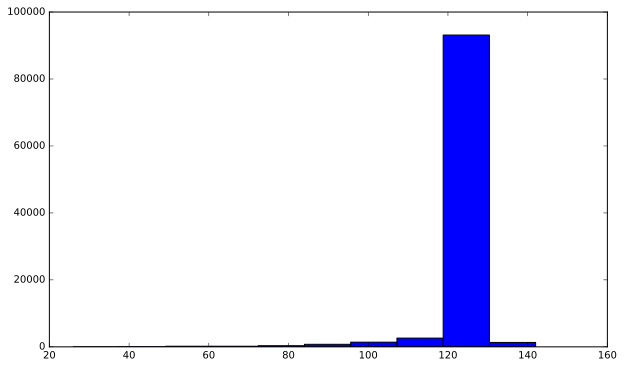

In [3]:
# This is Illumina sequencing, so read length should average 120
plt.hist([len(read) for read in random.sample(reads, int(1e5))]);

What we want to do is cluster our reads by a 50 bp section in each transcript that is flanked by invariant sequences. That 50 bp section is the independent variable in these experiments, and was completely randomized.

Once the reads are grouped by that 50 bp region (our hope is that there are many reads per unique 50 bp region), we can produce mismatch scores (indicating methylation) as well as positional coverage (low read coverage also indicates methylation).

To do alignments, we'll be using either Needleman-Wunsch (global pairwise alignment) or MAFFT (local multiple alignment), depending on whether we are aligning against a reference (Needleman-Wunsch) or many-to-many (MAFFT). In particular, we'll be using the Coral package (developed by Nick), which has these aligners built-in and convenient.

In [4]:
import coral as cr

for aln in cr.alignment.MAFFT([cr.ssDNA(read) for read in reads[:10]]):
    print aln[:100]

---------CACCCNTTACTGCTTACTGGCTTATCGAAATT----TCTGACGAGGGCTCTCCAACAGTAATGAATGGGTGGAAA--GAGTCACAGGANTG
--AGTGGNGGAGAACCCACT-CTTACTGGCTTATCGAAATT----CCATCAAGGTTCGCTAG-----------------------------------ATG
----AACGCNTCAACCCACTGCTTACTGGCTTATCGAAATT----ATATGTTCAGAGCCTA--CAGATGAAAGCCACTCGTACCGATTTGACNTATTATG
----CAGGTNACAACCCACTGCTTACTGGCTTATCGAAATT----TGTAGTTAGTGATCTGATTGCGTTGAACCAGCTGGTATT--TTACGGNCATAATG
CACGCNCAAGAGAACCCACTGCTTACTGGCTTATCGAAATTCTTCTAAGGATCGTGAGTTCCCACGAATGTATATAAGTGGANG-----CCGTGACAATG
--CCAGTNAGAGAACCCACTGCTTACTGGCTTATCGAAATT----GATCGATTGCAACAAATTCCTACCGTGTTCTGTACAAGT--TGTGNTTTAACATG
--AGCAGNAAAGAACCCACTGCTTACTGGCTTATCGAAATT----AATACGTTCTGGCTGTCTATTACAATACCGACCAACTGT--ACTGTGTAG--ATG
-TAGCANTG--GAACCCACTGCTTACTGGCTTATCGAAATT----TCAATCCTCGGGTCCCGGACATAACTATATCTGCTCCAA--GATTCCCGATTATG
----ACAGGNAGAACCCACTGCTTACTGGCTTATCGAAATT----TATTAATTGTGTACGAGTACGCAGGTATCCAGGAATAGT--TA-GCCTAGGTATG
--GGCAANGAAGAACCCACTGCTTACTGGCTTATCGAAATT----ACAGGTTCCCGGAAATGTCCGTAGGTAGGCGCCCCTCTA--TCCCA

It's clear that we have a conserved sequence near the 5' end of our reads. Our collaborator didn't initially tell us the sequence, just that it was 30 bases, but we determined it to be GAACCCACTGCTTACTGGCTTATCGAAATT anyways.

In [5]:
utr_inv = 'GAACCCACTGCTTACTGGCTTATCGAAATT'
len(utr_inv)

30

In [6]:
import coral as cr

for aln in cr.alignment.MAFFT([cr.ssDNA(read) for read in reads[:10]]):
    print aln[-80:]

ATGGGTGGAAA--GAGTCACAGGANTGCCTCCCGAGAAGAAGATCAAGAGCGTNAGCAAAGNTCNGAAGNGC--------
------------------------ATGCCTCCCGAGAAGAAGATCAAGAGCNTGAGCAA---------------------
CCACTCGTACCGATTTGACNTATTATGCCTCCCGAGAAGAAGATCAAGNGCGTGAGNAANGATCNGA-------------
CAGCTGGTATT--TTACGGNCATAATGCCTCCCGAGAAGAAGATCAAGNGCGTGAGCAANGATCNGA-------------
ATAAGTGGANG-----CCGTGACAATGCCTCCCGAGAAGAAGANCAAGAGCGTGNGCAANGANNNNNNNA----------
TCTGTACAAGT--TGTGNTTTAACATGCCTCCCGAGAAGAAGATCANGAGCGTGAGCNAAGANCGNNNNNNNA-------
CGACCAACTGT--ACTGTGTAG--ATGCCTCCCCAGAAGAAGATCAAGNGCGTGAGCAANGATCNGANNAGNNNA-----
ATCTGCTCCAA--GATTCCCGATTATGCCTCCCGAGAAGAAGATCAANAGCGTGAGCANAGATNGGAAGANNACNCG---
CCAGGAATAGT--TA-GCCTAGGTATGCCTCCCGAGAAGAAGATCAAGANCGTGAGCAAANATCGNAAGAGCNNACNTCT
GCGCCCCTCTA--TCCCACGGGCGATGCCTCCCGAGAAGAAGATCANGAGCGTGAGCNAAGANCGGAAGANCANACG---


There's another conserved sequence at the end of the reads - this is a coding sequence for mCherry, which will eventually serve as an indicator of expression. We'll use the first 30 bases of it for alignment: ATGCCTCCCGAGAAGAAGATCANGAGCGTG

In [7]:
mch = 'ATGCCTCCCGAGAAGAAGATCANGAGCGTG'
len(mch)

30

So, our task is to get the sequence between these two regions for clustering later on.

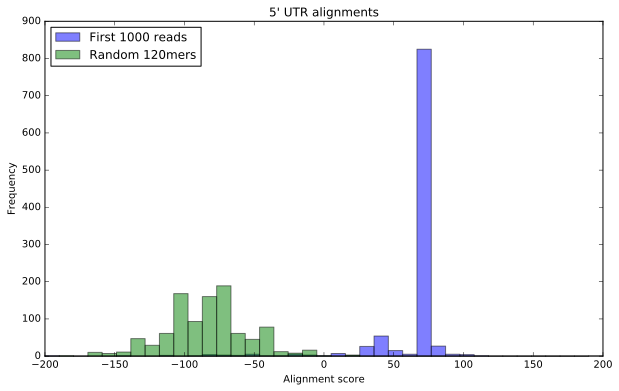

In [8]:
def align_score(seq1, seq2):
    aln = cr.alignment.needle(cr.ssDNA(seq1), 
                              cr.ssDNA(seq2), 
                              gap_extend=-1, 
                              gap_open=-30,
                              matrix=cr.alignment.substitution_matrices.DNA_SIMPLE * 16)
    return aln[2]

utr_aln = [align_score(utr_inv[-15:], read) for read in reads[:1000]]
utr_aln_rand = [align_score(utr_inv[-15:], cr.random.random_dna(120)) for i in range(1000)]

plt.hist(utr_aln, 
         alpha=0.5, 
         bins=np.linspace(-200, 200, 40),
         label='First 1000 reads');
plt.hist(utr_aln_rand,
         alpha=0.5, 
         bins=np.linspace(-200, 200, 40),
         label='Random 120mers');
plt.xlabel('Alignment score')
plt.ylabel('Frequency')
plt.title("5' UTR alignments")
plt.legend(loc='upper left');

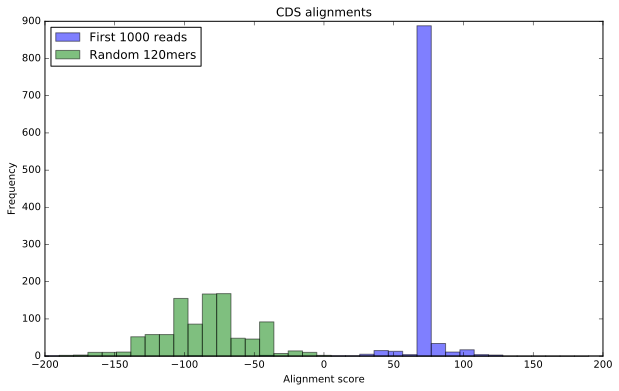

In [9]:
mch_aln = [align_score(mch[:15], read) for read in reads[:1000]]
mch_aln_rand = [align_score(mch[:15], cr.random.random_dna(120)) for i in range(1000)]

plt.hist(mch_aln, 
         alpha=0.5, 
         bins=np.linspace(-200, 200, 40),
         label='First 1000 reads');
plt.hist(mch_aln_rand,
         alpha=0.5, 
         bins=np.linspace(-200, 200, 40),
         label='Random 120mers');
plt.xlabel('Alignment score')
plt.ylabel('Frequency')
plt.title('CDS alignments')
plt.legend(loc='upper left');

This is how often we get non-50 bp regions: 0.1368


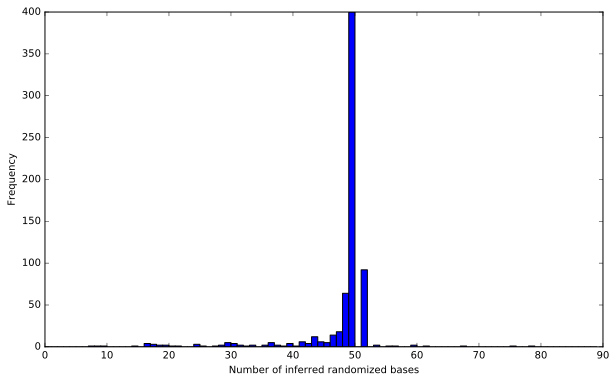

In [103]:
def trim_read(read):
    utr_inv = 'GAACCCACTGCTTACTGGCTTATCGAAATT'
    mch = 'ATGCCTCCCGAGAAGAAGATCANGAGCGTG'
    # Number of bases to which to align each read
    aln_bases = 15
    
    utr_ref = utr_inv[-aln_bases:]
    mch_ref = mch[:aln_bases]
    
    def align(seq1, seq2):
        '''Does Needleman-Wunsch alignment on two sequences using settings that
        heavily penalize mismatches. This is used to reject bad reads.'''
        try:
            aln = cr.alignment.needle(cr.ssDNA(seq1, run_checks=False), 
                                      cr.ssDNA(seq2), 
                                      gap_extend=-1, 
                                      gap_open=-30,
                                      matrix=cr.alignment.substitution_matrices.DNA_SIMPLE * 16)
        except:
            return None
        return aln
    
#     def align_contiguous(seq1, seq2):
#         '''Does Needleman-Wunsch alignment on two sequences using settings that
#         heavily penalize non-contiguous alignments.'''
#         try:
#             aln = cr.alignment.needle(cr.ssDNA(seq1), 
#                                       cr.ssDNA(seq2), 
#                                       gap_extend=-1, 
#                                       gap_open=-30,
#                                       matrix=cr.alignment.substitution_matrices.DNA_SIMPLE * 16)
#         except:
#             return None
        
#         return aln
    
    # Align to invariant UTR region to score matchiness
    utr_aln = align(utr_ref, read)
    if utr_aln is None:
        return None
    utr_score = utr_aln[2]
    if utr_score < 0:
        return None
    
    # Re-align to get a contiguous-ish alignment, remove 5' bases
    # utr_aln = align_contiguous(utr_ref, read)
    leftover = read[len(str(utr_aln[0]).rstrip('-')):]
    
    # Align to mCherry sequence to score matchiness
    mch_aln = align(mch_ref, leftover)
    if mch_aln is None:
        return None
    mch_score = mch_aln[2]
    if mch_score < 0:
        return None
    
    # Re-align to get a contiguous-ish alignment, remove 3' bases
    # mch_aln = align_contiguous(cr.ssDNA(mch_ref), cr.ssDNA(leftover))
    
    to_return = leftover[:len(leftover) - len(str(mch_aln[0]).lstrip('-'))]
    
    return str(to_return)

count = 0
n = 5000
trimmed_reads = [trim_read(read) for read in random.sample(reads, n)]
lens = [len(trimmed) for trimmed in trimmed_reads if trimmed is not None]
count = sum([1 for l in lens if l != 50])
plt.hist([l for l in lens if l != 50], bins=range(90));
plt.ylabel('Frequency')
plt.xlabel('Number of inferred randomized bases')

print 'This is how often we get non-50 bp regions: {}'.format(count / float(n))

We're going to assume that it's okay to have variable lengths and cluster anyways. We're going to use the Starcode software package to cluster these ~50mers for us.

In [105]:
with open('./reads1_trimmed.in', 'w') as g:
    for read in reads:
        trimmed = trim_read(read)
        if trimmed is not None:
            g.write(trimmed + '\n')

In [ ]:
!./starcode/starcode